In [17]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, f1_score 
import pickle


La lógica detras de balancear primero antes de seleccionar las mejores caracteristicas es reflejar mejor la informacion que proporciona la clase minoritaria (reducir el sesgo de la clase mayoritaria.)

In [13]:
datos_diabetes = pd.read_csv('/home/juan/machineLearning2025/datasets/diabetes_012_health_indicators_BRFSS2015.csv')
#Crear la columna diabetes_01 que unifique prediabetes con diabetes
datos_diabetes['diabetes_01'] = datos_diabetes['Diabetes_012']
datos_diabetes['diabetes_01'] = datos_diabetes['diabetes_01'].replace(2,1)

#Reparar nombres de columnas. Se usa el formato loweCamelCase para el nombre de las caracteristicas.

new_col_names = []

for name in datos_diabetes.columns:
    # Luego, pon todas las letras en minúsculas
    name_lowered_first_letter = name[0].lower() + name[1:]
    # Elimina los espacios al principio y al final
    name_stripped = name_lowered_first_letter.strip()
    # Por último, reemplaza los espacios entre palabras por guiones bajos
    name_no_spaces = name_stripped.replace(' ', '_')
    # Agrega el nuevo nombre a la lista de nuevos nombres de columna
    new_col_names.append(name_no_spaces)

datos_diabetes.columns = new_col_names

datos_diabetes = datos_diabetes.rename(columns={'bMI':'bmi'})

datos_diabetes.columns


Index(['diabetes_012', 'highBP', 'highChol', 'cholCheck', 'bmi', 'smoker',
       'stroke', 'heartDiseaseorAttack', 'physActivity', 'fruits', 'veggies',
       'hvyAlcoholConsump', 'anyHealthcare', 'noDocbcCost', 'genHlth',
       'mentHlth', 'physHlth', 'diffWalk', 'sex', 'age', 'education', 'income',
       'diabetes_01'],
      dtype='object')

In [14]:
#Definicion de datos enteros.
for col in datos_diabetes.columns:
    #if datos_diabetes[col].dtype == 'float64':
    datos_diabetes[col] = datos_diabetes[col].astype(int)


#Ver balanceo de la clase objetivo. Diabetes_012
porcentaje = 100*datos_diabetes['diabetes_012'].value_counts()/len(datos_diabetes)
print(porcentaje.astype(str) + '%')
datos_diabetes.drop(columns=['physHlth', 'mentHlth'], inplace=True)

diabetes_012
0     84.24116997792494%
2    13.933301797540208%
1     1.825528224534847%
Name: count, dtype: object


In [15]:
#Funciones run_model() y evaluate_model()


def run_model(X_train, X_test, Y_train, Y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, Y_train)
    return clf_base
def evaluate_model(model, train_features, train_target, test_features, test_target):
   
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')   
        
        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return  df_eval_stats, fig#eval_stats['train']['F1'], eval_stats['test']['F1']

In [16]:
#Hacemos prueba de regresion logistica para el dataset desbalanceado
X = datos_diabetes.drop(["diabetes_01", "diabetes_012"], axis=1)
y = datos_diabetes["diabetes_01"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


Modelo desbalanceado
           train  test
Exactitud   0.85  0.85
F1          0.28  0.28
APS         0.43  0.43
ROC AUC     0.82  0.82


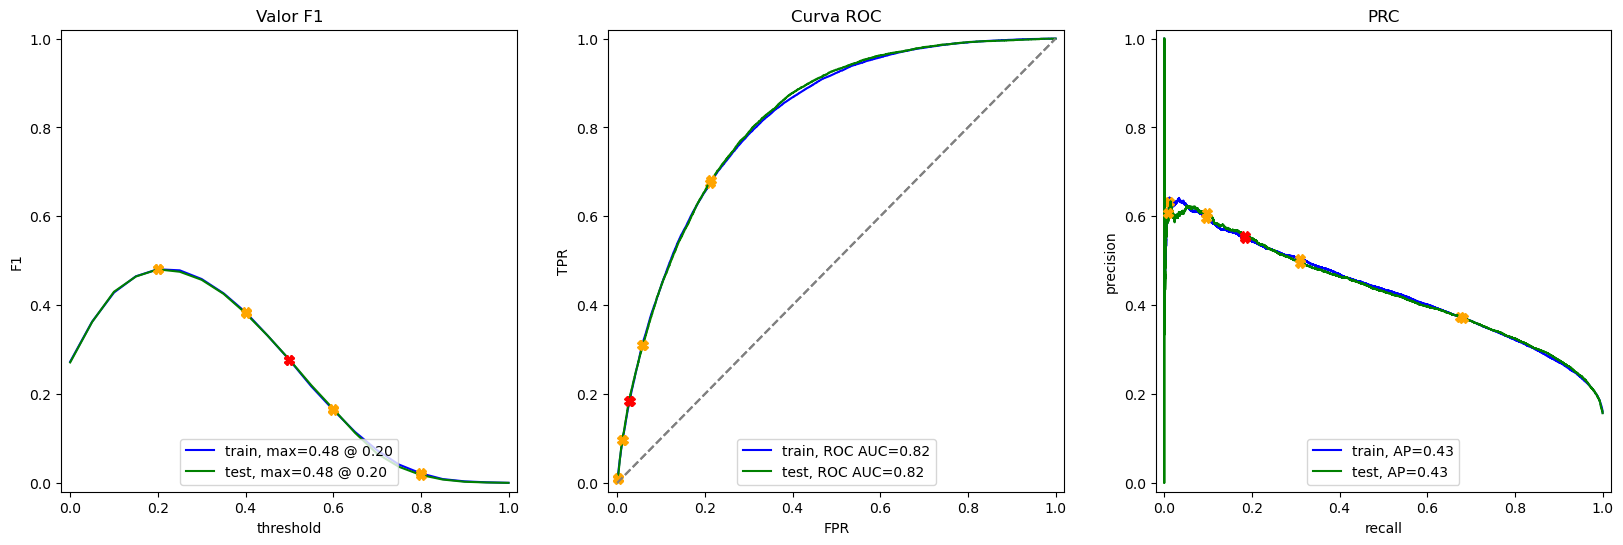

In [11]:
import pickle
model_desbalanceado = run_model(X_train, X_test, y_train, y_test)
print('Modelo desbalanceado')
df_metrics, fig_plots = evaluate_model(model_desbalanceado, X_train, y_train, X_test, y_test)

df_metrics.to_csv('metrics_logreg_unbalanced.csv')

with open('fig_logreg_unbalanced.pkl', 'wb') as f:
    pickle.dump(fig_plots, f)


Text(0.5, 1.0, 'Confusion matrix desbalanced Dataset')

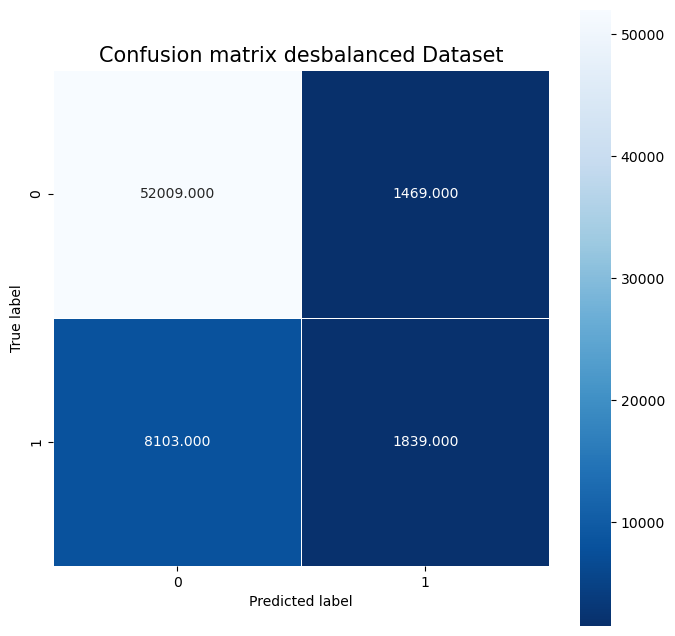

In [7]:
#matriz de confusion

y_pred_desbalanceado = model_desbalanceado.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred_desbalanceado)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix desbalanced Dataset', size = 15)

Modelo balanceado mediante pesos
           train  test
Exactitud   0.73  0.73
F1          0.47  0.47
APS         0.43  0.43
ROC AUC     0.82  0.82


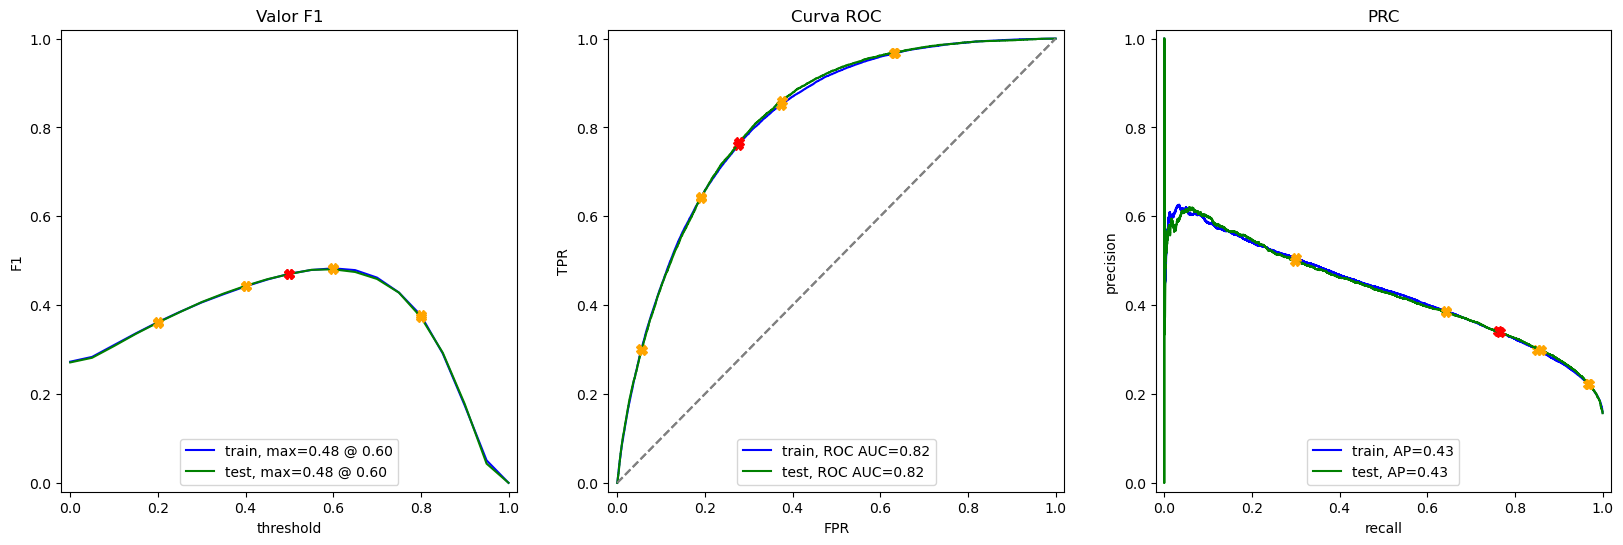

In [8]:
###MODELO BALANCEADO utilizando pesos en regresion log
def run_model_balanced_1(X_train, X_test, Y_train, Y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, Y_train)
    return clf

print('Modelo balanceado mediante pesos')
model_balanced = run_model_balanced_1(X_train, X_test, y_train, y_test)
train_f1, test_f1 = evaluate_model(model_balanced, X_train, y_train, X_test, y_test)


Conclusiones de las graficas Dataset desbalanceado vs Balance con regresion lineal ponderada:

*Mismo maximo de F1 de 0.48, con distinto umbral, 0.2 y 0.6 respectivamente.

*Se mantiene el area bajo la curva ROC para ambos casos

*La exactitud (accuracy) disminuye de 0.85 a 0.73, es decir, el modelo balancedo es menos exacto prediciendo las clases de manera global.




Text(0.5, 1.0, 'Confusion matrix')

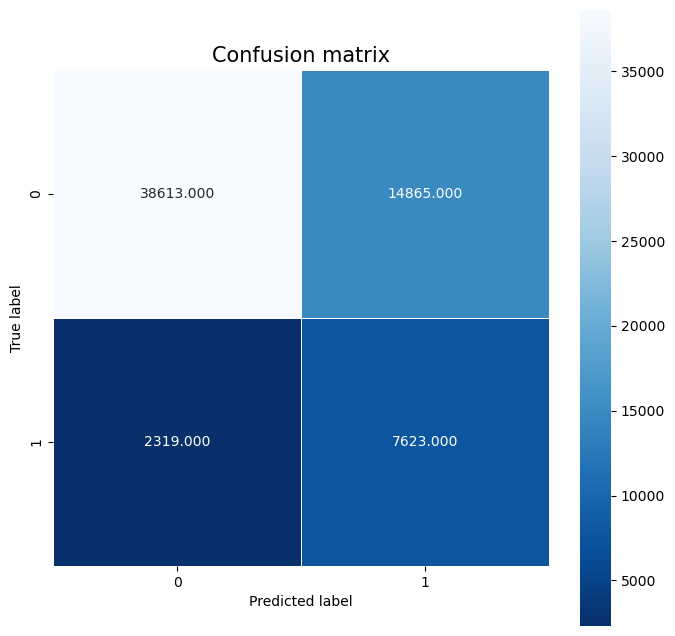

In [9]:
#matriz de confusion

y_pred_balanced= model_balanced.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred_balanced)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix', size = 15)

In [10]:
print(f'Metricas del dataset desbalanceado')
print(f'Precision: {precision_score(y_test, y_pred_desbalanceado)}')
print(f'Recall: {recall_score(y_test, y_pred_desbalanceado)}')
print(f'F1: {f1_score(y_test, y_pred_desbalanceado)}')

print(f'Metricas del dataset balanceado 1')
print(f'Precision: {precision_score(y_test, y_pred_balanced)}')
print(f'Recall: {recall_score(y_test, y_pred_balanced)}')
print(f'F1: {f1_score(y_test, y_pred_balanced)}')

Metricas del dataset desbalanceado
Precision: 0.555925030229746
Recall: 0.18497284248642124
F1: 0.27758490566037736
Metricas del dataset balanceado 1
Precision: 0.33898078975453577
Recall: 0.7667471333735667
F1: 0.47012025901942645


           train  test
Exactitud   0.77  0.77
F1          0.48  0.48
APS         0.43  0.43
ROC AUC     0.82  0.82


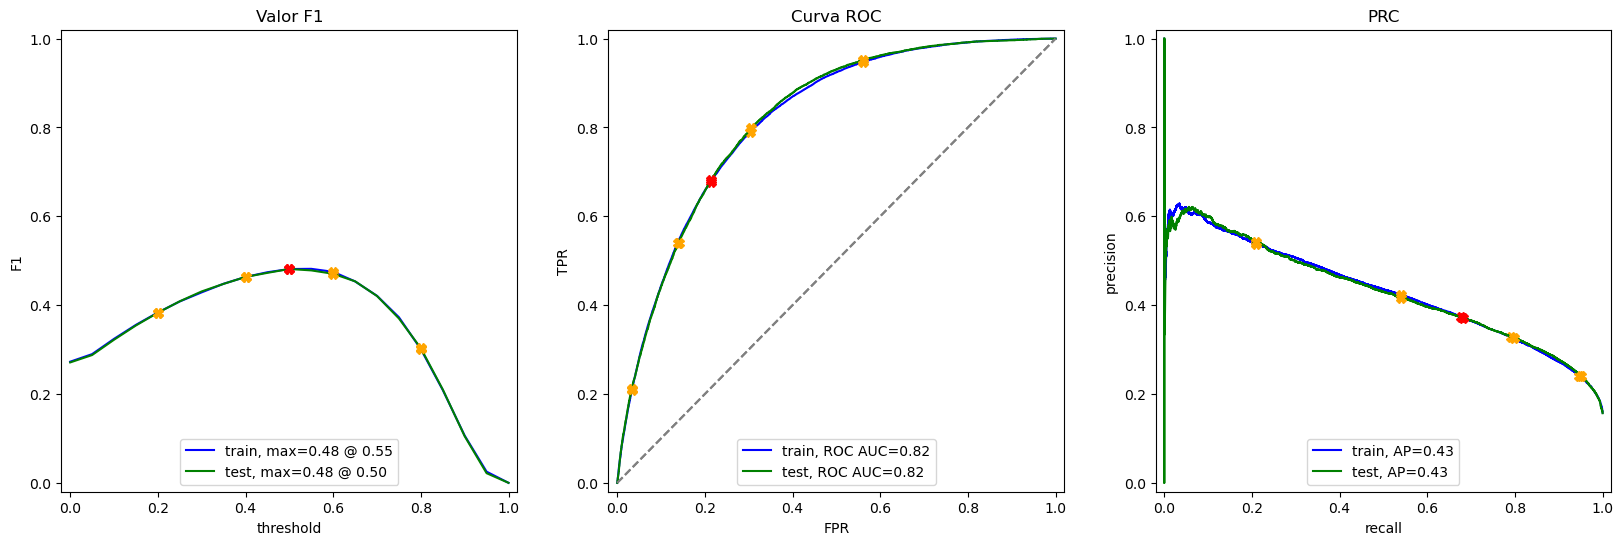

In [11]:
def run_model_balanced_2(X_train, X_test, Y_train, Y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight={0: 0.2,1: 0.8})
    clf.fit(X_train, Y_train)
    return clf

model_balanced2 = run_model_balanced_2(X_train, X_test, y_train, y_test)

y_pred_balanced2 = model_balanced2.predict(X_test)
train_f1, test_f1 = evaluate_model(model_balanced2, X_train, y_train, X_test, y_test)


In [18]:
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter  


before resampling Counter({0: 160225, 1: 30035})
after resampling Counter({0: 30035, 1: 30035})
           train  test
Exactitud   0.84  0.57
F1          0.83  0.37
APS         0.92  0.30
ROC AUC     0.91  0.72


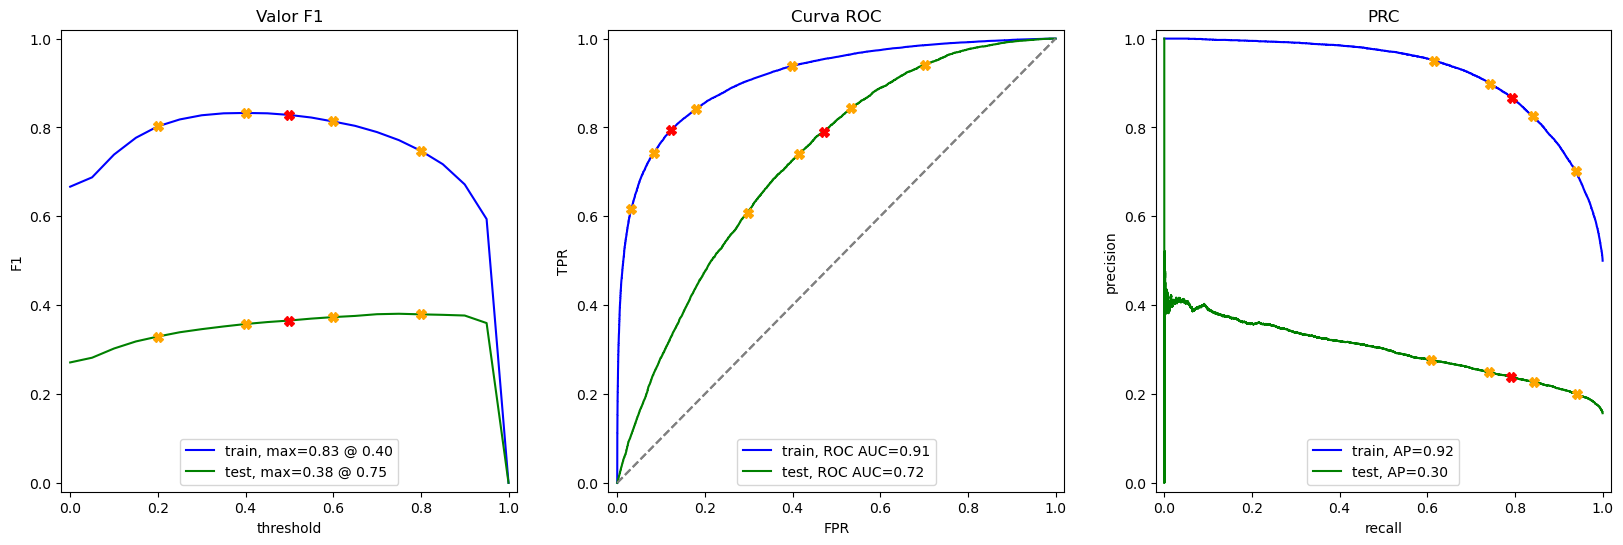

In [24]:

us = NearMiss()
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_res)))
 
model = run_model(X_train_res, X_test, y_train_res, y_test)
y_pred = model.predict(X_test)
df_metrics, fig_plots = evaluate_model(model, X_train_res, y_train_res, X_test, y_test) 

df_metrics.to_csv('metrics_logreg_NearMiss.csv')

with open('fig_logreg_NearMiss.pkl', 'wb') as f:
    pickle.dump(fig_plots, f)

before resampling Counter({0: 160225, 1: 30035})
after resampling Counter({0: 160225, 1: 160225})
           train  test
Exactitud   0.74  0.73
F1          0.75  0.47
APS         0.79  0.43
ROC AUC     0.82  0.82


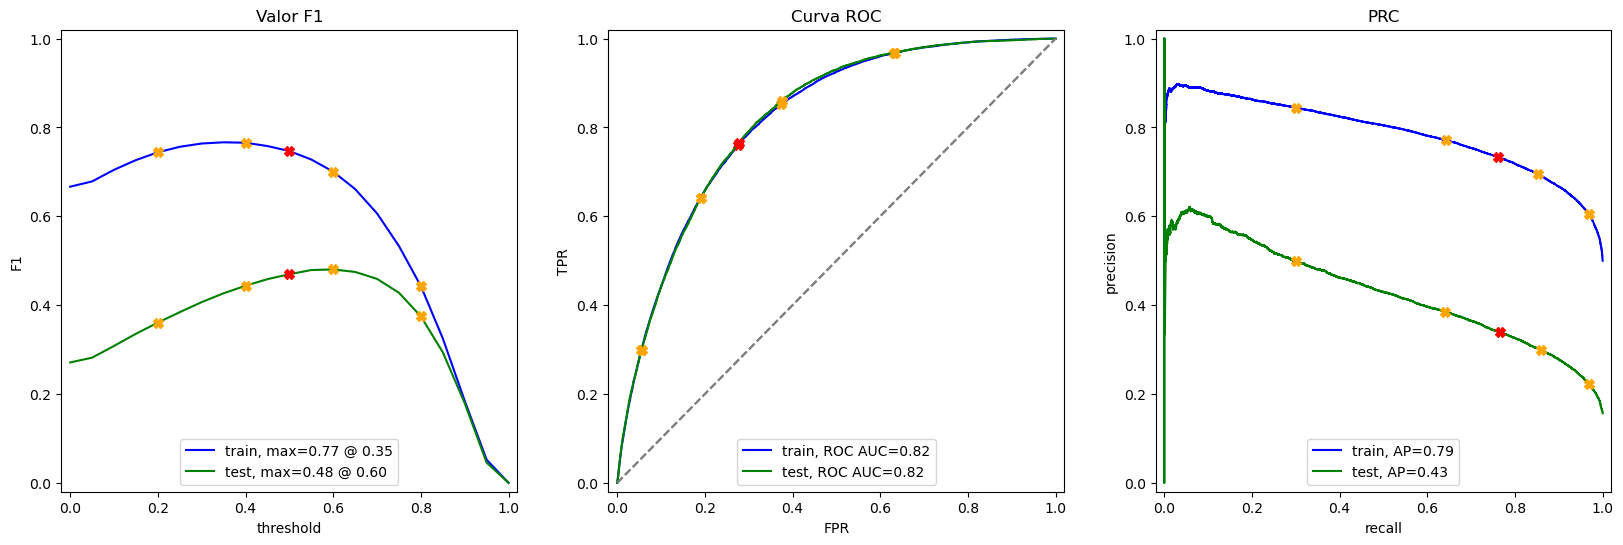

In [13]:
#RandomOverSampler, crea muestras sinteticas nuevas de la clase minoritaria.

os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_res)))
 
model = run_model(X_train_res, X_test, y_train_res, y_test)
y_pred = model.predict(X_test)
df_metrics, fig_plots = evaluate_model(model, X_train_res, y_train_res, X_test, y_test) 

df_metrics.to_csv('metrics_logreg_RandomOverSampler.csv')

with open('fig_logreg_RandomOverSampler.pkl', 'wb') as f:
    pickle.dump(fig_plots, f)


before resampling Counter({0: 160225, 1: 30035})
after resampling Counter({0: 160225, 1: 160225})
           train  test
Exactitud   0.73  0.72
F1          0.74  0.46
APS         0.78  0.40
ROC AUC     0.81  0.80


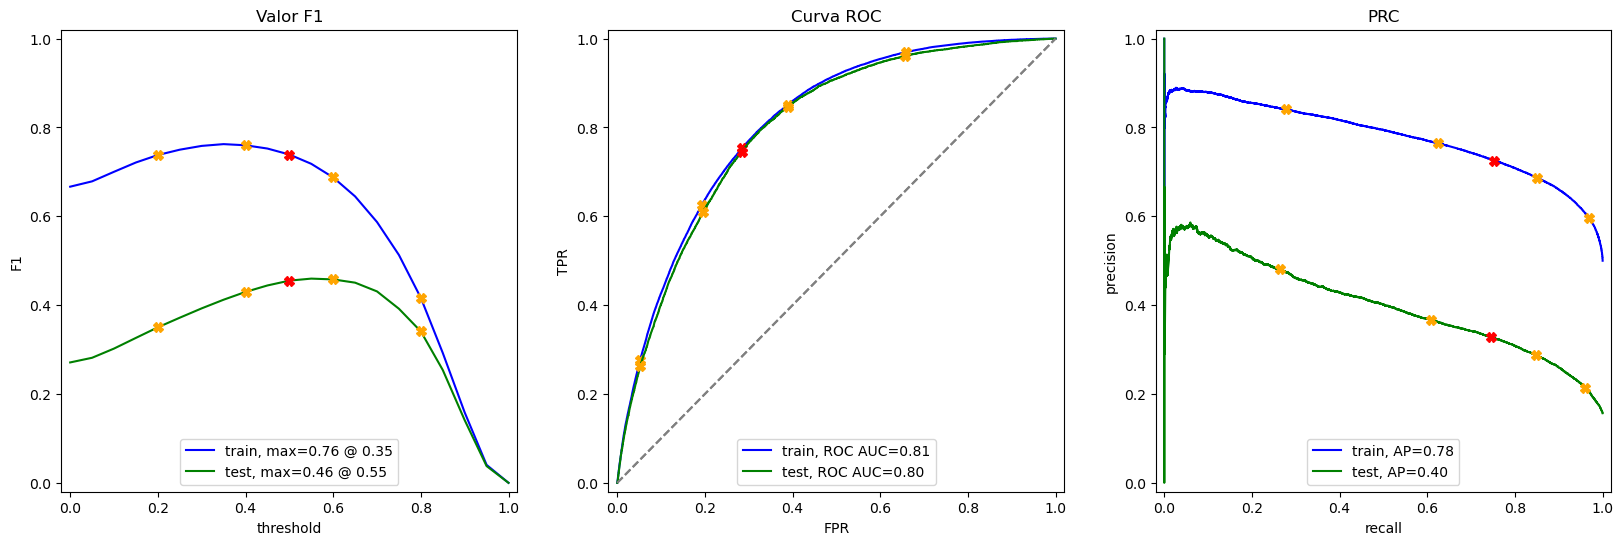

In [14]:
#SMOTE resampleo de la clase minoritaria sin duplicados
os_us = SMOTE()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_res)))
 
model = run_model(X_train_res, X_test, y_train_res, y_test)
y_pred = model.predict(X_test)
df_metrics, fig_plots = evaluate_model(model, X_train_res, y_train_res, X_test, y_test)

df_metrics.to_csv('metrics_logreg_SMOTE.csv')

with open('fig_logreg_SMOTE.pkl', 'wb') as f:
    pickle.dump(fig_plots, f)


before resampling Counter({0: 160225, 1: 30035})
after resampling Counter({0: 160225, 1: 80112})
           train  test
Exactitud   0.75  0.81
F1          0.57  0.46
APS         0.64  0.41
ROC AUC     0.81  0.81


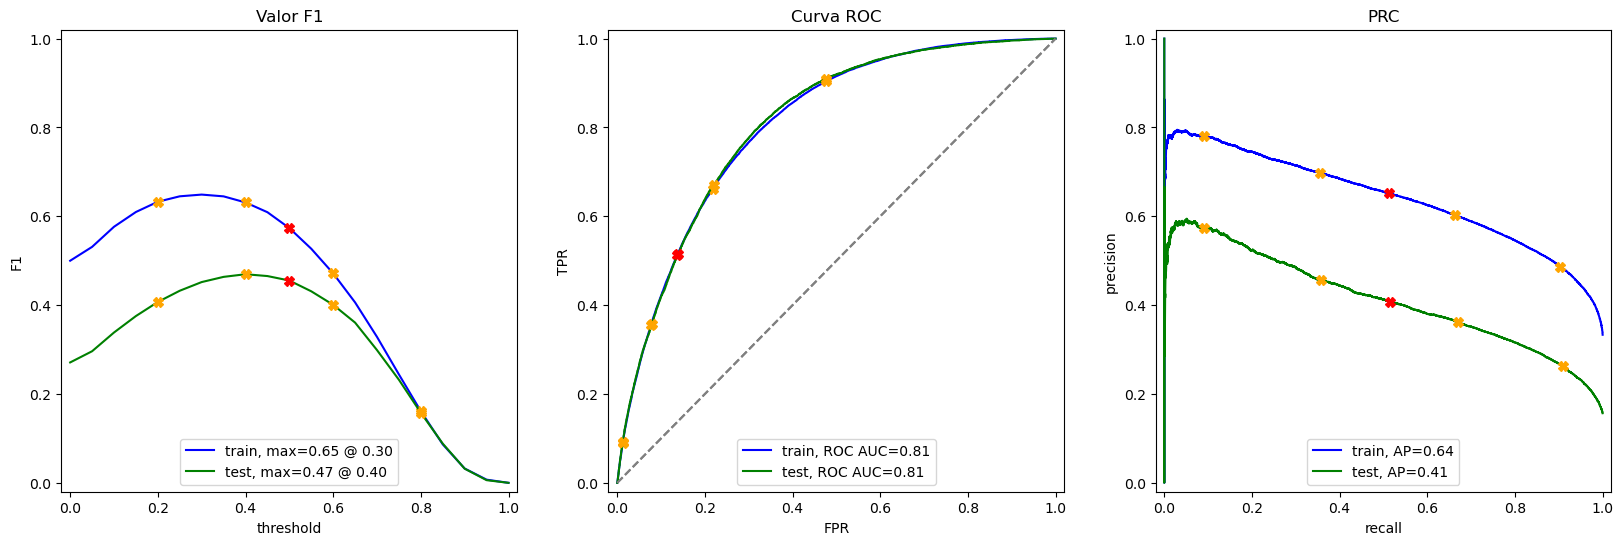

In [19]:
#SMOTE resampleo de la clase minoritaria sin duplicados CON SAMPLING STRATEGY
os_us3 = SMOTE(sampling_strategy=0.5, random_state=4321)
X_train_res_smote2, y_train_res_smote2 = os_us3.fit_resample(X_train, y_train)
 
print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_res_smote2)))
 
model = run_model(X_train_res_smote2, X_test, y_train_res_smote2, y_test)
y_pred = model.predict(X_test)
df_metrics, fig_plots = evaluate_model(model, X_train_res_smote2, y_train_res_smote2, X_test, y_test)

df_metrics.to_csv('metrics_logreg_SMOTE_samp_0,5.csv')

with open('fig_logreg_SMOTE_samp_0,5.pkl', 'wb') as f:
    pickle.dump(fig_plots, f)

before resampling Counter({0: 160225, 1: 30035})
after resampling Counter({0: 160225, 1: 96135})
           train  test
Exactitud   0.74  0.79
F1          0.63  0.46
APS         0.68  0.41
ROC AUC     0.81  0.81


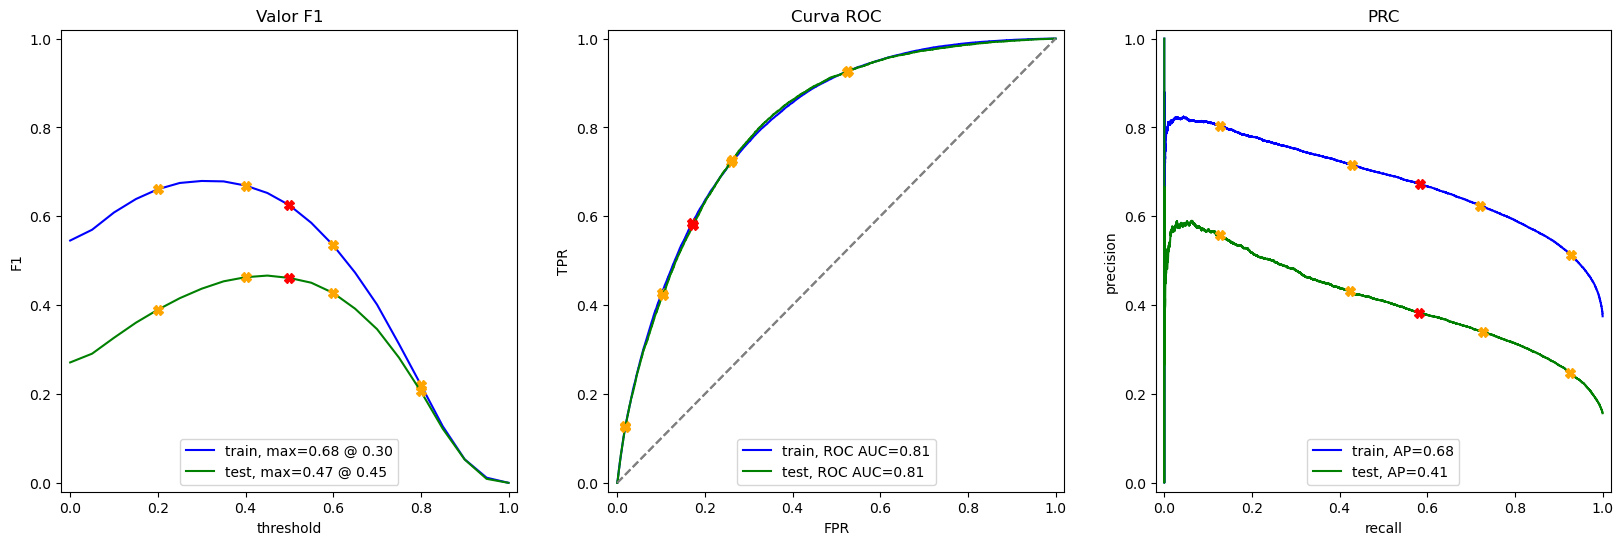

In [21]:
#SMOTE resampleo de la clase minoritaria sin duplicados CON SAMPLING STRATEGY
os_us3 = SMOTE(sampling_strategy=0.6, random_state=4321)
X_train_res_smote2, y_train_res_smote2 = os_us3.fit_resample(X_train, y_train)
 
print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_res_smote2)))
 
model = run_model(X_train_res_smote2, X_test, y_train_res_smote2, y_test)
y_pred = model.predict(X_test)
df_metrics, fig_plots = evaluate_model(model, X_train_res_smote2, y_train_res_smote2, X_test, y_test)

before resampling Counter({0: 160225, 1: 30035})
after resampling Counter({0: 157756, 1: 157756})
           train  test
Exactitud   0.74  0.72
F1          0.74  0.45
APS         0.79  0.40
ROC AUC     0.81  0.80


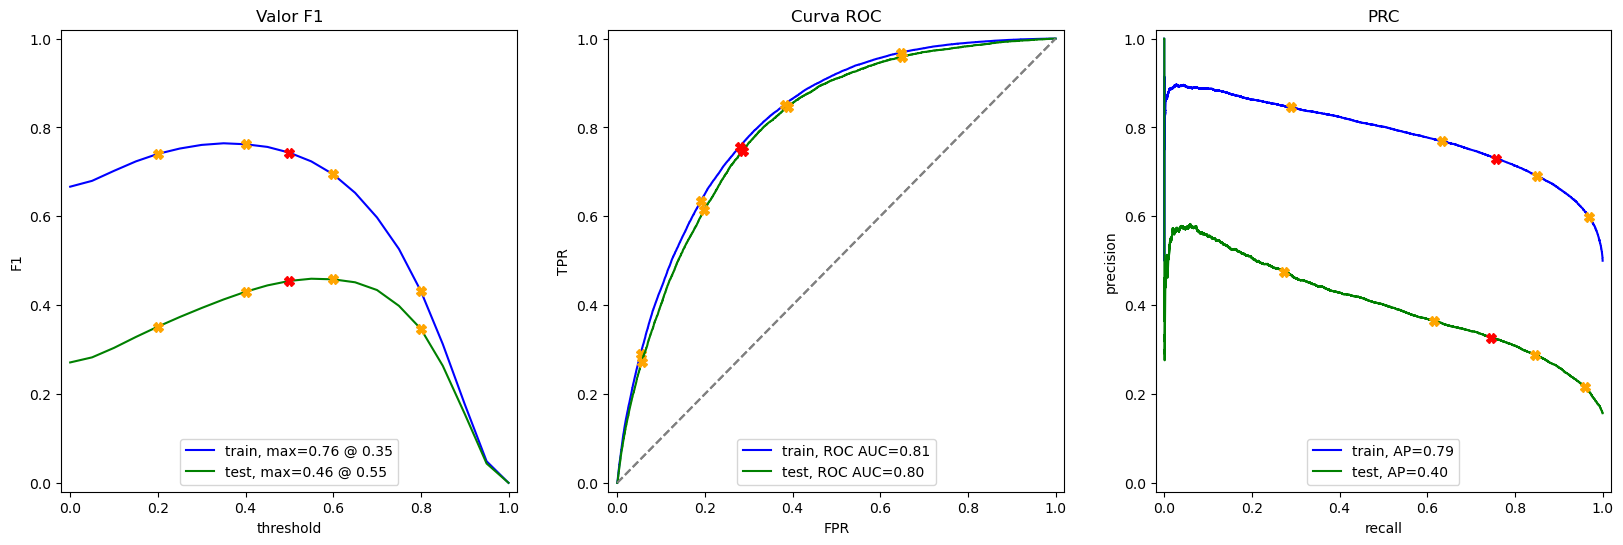

In [22]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_res)))
 
model = run_model(X_train_res, X_test, y_train_res, y_test)
y_pred = model.predict(X_test)

train_f1, test_f1 = evaluate_model(model, X_train_res, y_train_res, X_test, y_test)

df_metrics.to_csv('metrics_logreg_SMOTETomek.csv')

with open('fig_logreg_SMOTETomek.pkl', 'wb') as f:
    pickle.dump(fig_plots, f)

before resampling Counter({0: 160225, 1: 30035})
after resampling Counter({0: 156793, 1: 76680})
           train  test
Exactitud   0.75  0.81
F1          0.58  0.46
APS         0.65  0.41
ROC AUC     0.81  0.81


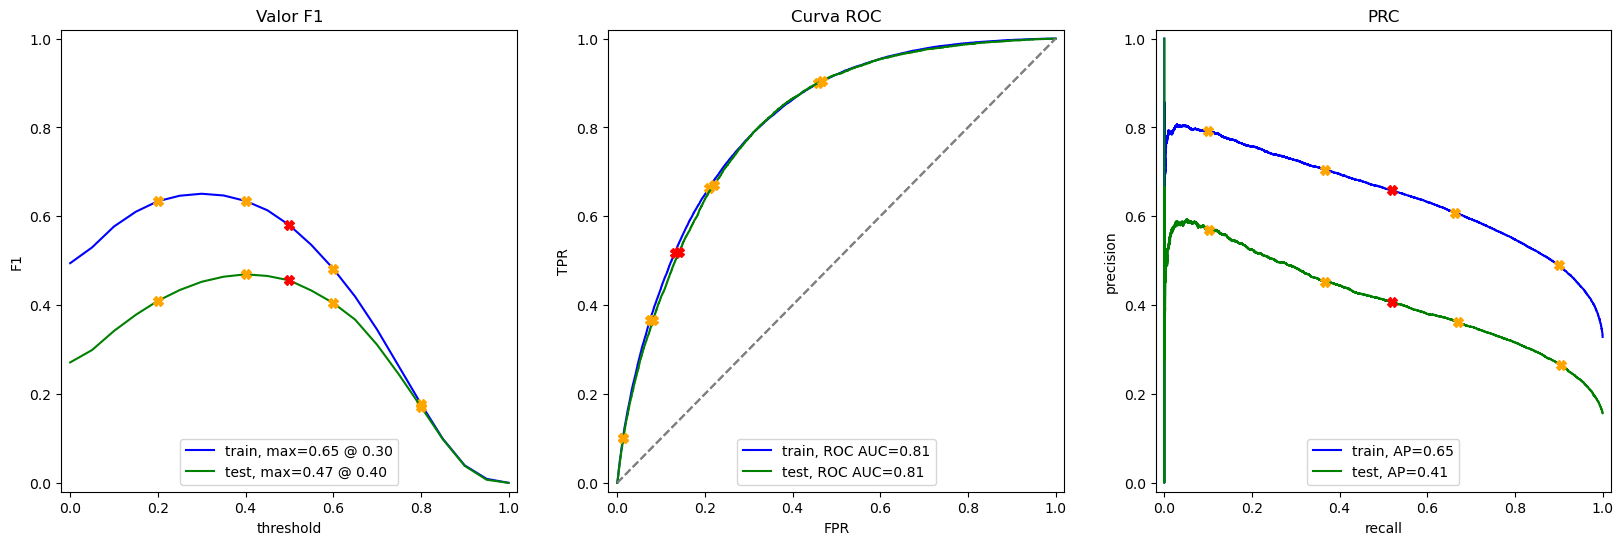

In [11]:
os_us2=SMOTETomek(sampling_strategy=0.5, random_state=4321, n_jobs=8)

X_train_res_smotetomek2, y_train_res_smotetomek2 = os_us2.fit_resample(X_train, y_train)
 
print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_res_smotetomek2)))
 
model = run_model(X_train_res_smotetomek2, X_test, y_train_res_smotetomek2, y_test)
y_pred = model.predict(X_test)

train_f1, test_f1 = evaluate_model(model, X_train_res_smotetomek2, y_train_res_smotetomek2, X_test, y_test)

           train  test
Exactitud   0.83  0.74
F1          0.64  0.47
APS         0.86  0.42
ROC AUC     0.96  0.81


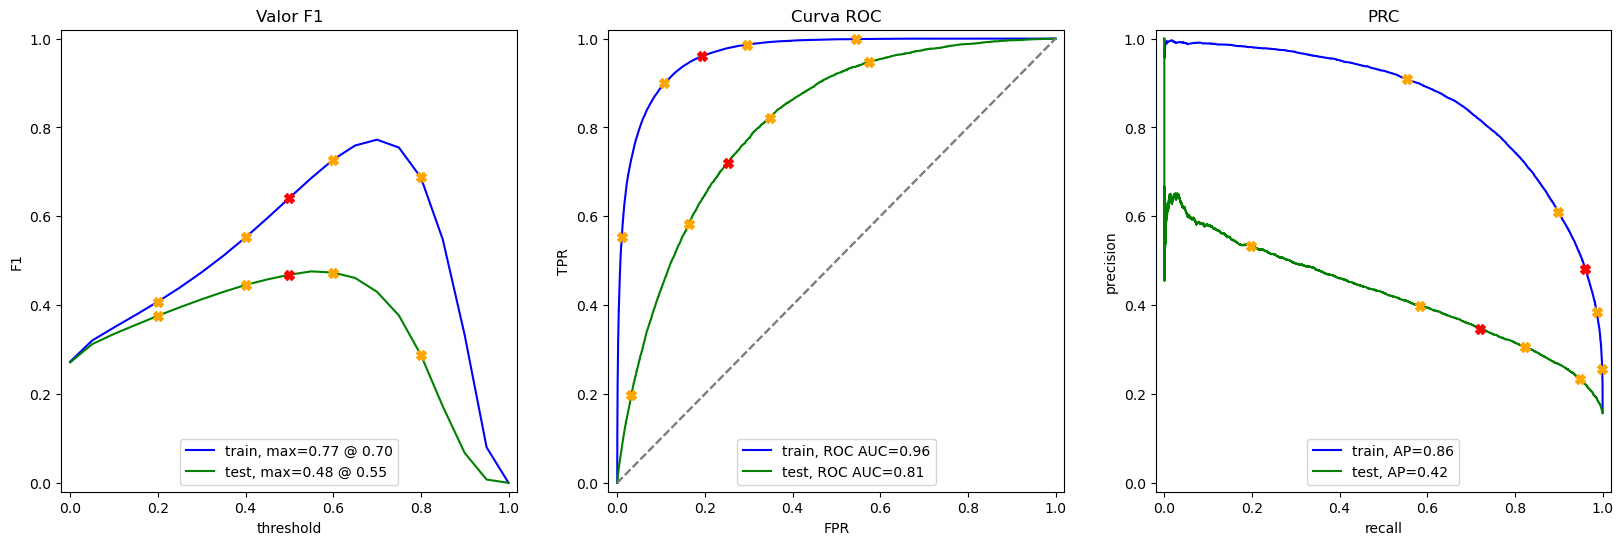

In [17]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Crear el BalancedBaggingClassifier con el argumento correcto
bbc = BalancedBaggingClassifier(estimator=RandomForestClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)


bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
train_f1, test_f1 = evaluate_model(bbc, X_train, y_train, X_test, y_test)

*El metodo de Bagging mejora con los datos de entrenamiento, pero ningun metodo mejora significativamente la generalizacion de las predicciones (evaluaciones con los datos de test).

*TOdos los balanceos me dan un AP bajo (menor a .50), lo que significa que el modelo sigue sin poder clasificar bien la clase positiva. EN este caso, la presicion es la que se ve mas afectada, lo que quiere decir que el modelo tiene muchos Falsos Positivos.

